<a href="https://colab.research.google.com/github/victorknox/Hate-Speech-Detection-in-Hindi/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subjectivity Analysis
- We use Sentiment lexicon resource for hindi called Hindi Sentiwordnet.
- It has around 3000 prior-polarity subjective clues with POS tag, positive score, negative score and related terms(seperated by comma)
- Algorithm used: 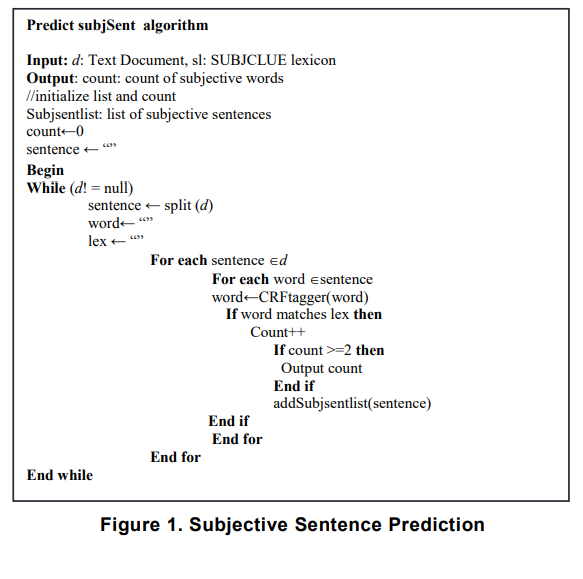


In [54]:
SUBJCLUE = []       # SUBJCLUE Data

with open('SUBJCLUE.txt') as f:   # Formatting SUBJCLUE Data
    for line in f:
      x = line.split()
      x[4] = x[4].split(',')
      SUBJCLUE.append(x)

# After this, the data would be in this form:
# ['POS tag', 'SYSNET ID(Hindi WN)', 'Positive score', 'Negative score', List of related words]


for key in SUBJCLUE[:5]:
  print(key[4])


['अनौपचारिक']
['मृत']
['परवर्ती']
['अच्छा', 'बढ़िया']
['सौभाग्यशाली', 'खुशकिस्मत', 'खुशनसीब', 'तक़दीर_वाला', 'नसीब_वाला', 'भाग्यवान', 'भाग्यशाली', 'ख़ुशक़िस्मत', 'ख़ुशनसीब']


## Reading the data


In [55]:
# importing csv module
import csv
# csv file name
filename = "valid.csv"
  
# initializing the titles and rows list
fields = []
rows = []
  
# reading csv file
with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
      
    # extracting field names through first row
    fields = next(csvreader)
  
    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)
  
    # get total number of rows
    print("Total no. of rows: %d"%(csvreader.line_num))
  
# printing the field names
print('Field names are:' + ', '.join(field for field in fields))
  
#  printing first 5 rows
# Appending a score for each row
tot = 0
for row in rows:
    row.append(tot)
    # print(row)
# can be accessed using row[3]
for row in rows[:5]:
  print(row)

Total no. of rows: 2259
Field names are:Unique ID, Post, Labels Set
['1', 'दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।\n\nउनका निधन हम सब के लिए अपूरणीय क्षति है।\nईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।\nऊं शांति!!!', 'non-hostile', 0]
['2', 'भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी  करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो', 'defamation', 0]
['3', 'कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू, राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया\nhttps://t.co/9rlQowAsFh #Delhi @ArvindKejriwal  @rajnathsingh @AmitShah @DRDO_India @WHO @crpfindia @ITBP_official', 'non-hostile', 0]
['4', 'गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चा

## Checking score

Finding positive and negative scores for each sentence



In [56]:
count = 0
for key in SUBJCLUE:
  subjlist = key[4]
# subjlist = ['इच्छा', 'आत्मा', 'इतने']
  for row in rows:
    if any([subjword in row[1] for subjword in subjlist]):
      count += 1
      pos = float(key[2])
      neg = float(key[3])
      tot = pos - neg
      row[3] += tot
      # if tot != 0:
        # print("id = " + row[0], "pos = " + str(pos), "neg = " + str(neg), "tot = " + str(tot) )

print(count)

10530


In [57]:
counter = 0
for row in rows:
  x = row[2].split(',')
  for word in x:
    if word == "hate":
      counter += 1

print(counter)

110


In [58]:
counter = 0
subj_rows = []
for row in rows:
  if row[3] <= -0.5 or row[3] >= 1: # subjective sentence condition
    subj_rows.append(row)
    # print(row[3], row[2])
    counter += 1

print(counter)
# for row in subj_rows:
#   print(row)




355


# Hate Lexicon Growing


In [59]:
!pip install stanza
!pip install setuptools
!pip install subzero
!pip install inltk

In [60]:
SYNSET = []
with open('Synset.txt', encoding= 'unicode_escape') as f:
    for line in f:
        x = line.split()
        x[3] = x[3].split(':')
        SYNSET.append(x)
# print(SYNSET[:5])

import stanza
stanza.download('hi', processors='tokenize,pos,lemma')

import csv
dataset = ""

for row in rows:
    dataset+=row[1]

verbs_content = []
nlp = stanza.Pipeline('hi',processors='tokenize,pos,lemma')
pos = open('hindi_pos.txt','w')
doc = nlp(dataset)
for sentence in doc.sentences:
     for word in sentence.words:
        #  print(word)
         # + "{:8s}".format(word.upos),file=pos)
         if word.upos == 'VERB':
             verbs_content.append(word.text)

strongly_negative_words = []
weakly_negative_words = []
for line in SUBJCLUE:
    totalscore = float(line[2]) - float(line[3])
    if(totalscore < -0.35):
      for word in line[4]:
        strongly_negative_words.append(word)
    elif totalscore < 0:
      for word in line[4]:
        weakly_negative_words.append(word)
        
def Getsynset(word):
    syn = []
    flag=0
    syn.append(word)
    for line in SYNSET:
        if(line[1]=="03"):
            for verb in line[3]:
                if(word == verb):
                    flag = 1
                    break
            if(flag):
                syn = line[3]
                break
    return syn
s = {}
hlex = []

slist = ["लड़ना" , "मारना" , "लूटना" , "पीटना" , "कूटना" , "भेदभाव" ,"फोड़ना", "तोड़ना", "उखाड़ना" ]
for word in slist:
  hlex.append(word)
for word in slist:
    s = Getsynset(word)
    for verb1 in s:
        if verb1 in verbs_content:
            hlex.append(verb1)
#print(hlex)            

2021-07-29 12:25:08 INFO: Downloading these customized packages for language: hi (Hindi)...
| Processor | Package |
-----------------------
| tokenize  | hdtb    |
| pos       | hdtb    |
| lemma     | hdtb    |
| pretrain  | hdtb    |

2021-07-29 12:25:08 INFO: File exists: /root/stanza_resources/hi/tokenize/hdtb.pt.
2021-07-29 12:25:08 INFO: File exists: /root/stanza_resources/hi/pos/hdtb.pt.
2021-07-29 12:25:08 INFO: File exists: /root/stanza_resources/hi/lemma/hdtb.pt.


2021-07-29 12:25:08 INFO: File exists: /root/stanza_resources/hi/pretrain/hdtb.pt.
2021-07-29 12:25:08 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-07-29 12:25:08 INFO: Loading these models for language: hi (Hindi):
| Processor | Package |
-----------------------
| tokenize  | hdtb    |
| pos       | hdtb    |
| lemma     | hdtb    |

2021-07-29 12:25:08 INFO: Use device: cpu
2021-07-29 12:25:08 INFO: Loading: tokenize
2021-07-29 12:25:08 INFO: Loading: pos
2021-07-29 12:25:09 INFO: Loading: lemma
2021-07-29 12:25:09 INFO: Done loading processors!


In [61]:
# open themenouns.txt in read
themed_nouns = open('themenouns.txt','r')
themenouns = []
for line in themed_nouns:
    themenouns.append(line.rstrip('\n'))
print(themenouns)

['बीजेपी ', 'मोदी ', 'माओवादियों ', 'इस्लाम ', 'धमकी ', 'सुरक्षा ', 'धर्म ', 'साले ', 'कुत्ते ', 'कुतिया', 'कुते ', 'कुत्ती', 'कुत्तो', 'कमीना', 'कमीनी', 'साला', 'साली', 'हरामी', 'हरामखोर', 'बहनचोद', 'मादरचोद', 'चूतिया', 'चूत', 'चुत', 'टट्टी', 'नाजायज', 'झांट', 'सुअर', 'बेटीचोद', 'गांड', 'भोसड़ी', 'रन्डी', 'रांड', 'भड़वे', 'लौड़ा', 'लोडे', 'लवड़ा', 'चोर ', 'औलाद ', 'चीन ', 'औकात ', 'चुनौती', 'कश्मीर ', 'ज़ुल्म ', 'मरकज ', 'भारत', 'आतंकवाद', 'इस्लामिक', 'तालिबानी', 'हिन्दू ', 'अर्नब ', 'गद्दारों ', 'कलंकित ', 'तोड़फोड़ ', 'शिवसेना ', 'मंदिर ', 'राम ', 'हिन्दुओं ', 'शूद्र ', 'मुसलमान ', 'विपक्षी ', 'आग ', 'कॉंग्रेस ', 'आतंकवादी ', 'डायन ', 'पलटू ', 'फेंकूँ ', 'पाकिस्तान ', 'जिंदाबाद ', 'आतंकी ', 'आतंकी ', 'आतंकियों ', 'हिंदुस्तान ', 'हिन्दुओं', 'नेता', 'गुलाम ', 'पीओके ', 'आरएसएस ', 'भैंसियो ', 'चमचों ', 'पिल्ला ', 'गधे ', 'तबाह ', 'मुसलमान ', 'मुसलमानों ', 'मौलवी ', 'धर्म ']


# Final Testing

In [62]:
print(strongly_negative_words)
print(weakly_negative_words)
print(hlex) 
print(themenouns)

['मृत', 'दुर्भाग्यशाली', 'अभागा', 'बदनसीब', 'भाग्यहीन', 'मनहूस', 'बदकिस्मत', 'मंदभाग्य', 'बदक़िस्मत', 'दईमारा', 'कमबख्त', 'कमबख़्त', 'अधन्य', 'अभागी', 'आवासहीन', 'आश्रयहीन', 'गृहहीन', 'गृहविहीन', 'बेघर', 'बेघरबार', 'अगतिक', 'अगेह', 'अनिकेत', 'बदबूदार', 'दुर्गंधपूर्ण', 'दुर्गंधयुक्त', 'दुर्गंधित', 'ढीला', 'अश्लिष्ट', 'असंयुक्त', 'असंयोजित', 'असंबद्ध', 'अलग', 'अजुड़ा', 'अजोड़', 'पृथक्', 'जुदा', 'पृथक', 'अपृक्त', 'पराधीन', 'गुलाम', 'परतंत्र', 'अन्याधीन', 'अपरवश', 'परवश', 'अवश', 'अबस', 'ढीला', 'जड़', 'अचैतन्य', 'जड़त्वयुक्त', 'स्थूल', 'अजैव', 'भौतिक', 'अचेतन', 'चेतनारहित', 'अजीव', 'अनात्म', 'आत्मारहित', 'अफल', 'अफलित', 'फलहीन', 'फलरहित', 'फलविहीन', 'निस्संतान', 'निःसंतान', 'बेऔलाद', 'संतानहीन', 'संतानरहित', 'अऊत', 'अनपत्य', 'भली-भाँति', 'भली_भाँति', 'भरपूर', 'भलीभाँति', 'भली-भांति', 'भली_भांति', 'भलीभांति', 'पंखहीन', 'पक्षरहित', 'अपक्ष', 'अपच्छी', 'अपत्र', 'अतकनीकी', 'ग़ैरतकनीकी', 'गैरतकनीकी', 'तकनीकहीन', 'प्राविधिहीन', 'दुर्गुणी', 'अगुणी', 'अपगुणी', 'ऐबी', 'खोटा', 'विपरीत', 'प्रतिकूल', 'ख

In [63]:
x = rows
for row in rows:
    strongcount = 0
    hlexcount = 0
    weakcount = 0
    themecount = 0
    if any([word in row[1] for word in strongly_negative_words]):
      strongcount += 1
    if any([word in row[1] for word in hlex]):
      hlexcount += 1
    if any([word in row[1] for word in weakly_negative_words]):
      weakcount += 1
    if any([word in row[1] for word in themenouns]):
      themecount += 1

    if strongcount >= 2:
        row.append("strongly hateful")
    elif strongcount == 1:
      if hlexcount >= 1 or themecount >= 1:
        row.append("strongly hateful")
      else:
        row.append("weakly hateful")
    elif strongcount == 0:
      if themecount >= 1 and hlexcount >= 1:
        row.append("strongly hateful")
      elif themecount >=1 and weakcount >= 1:
        row.append("weakly hateful")
      elif hlexcount == 1:
        row.append("weakly hateful")
      else:
        row.append("No Hate")

In [64]:
import csv

fields = ['Unique ID', 'Post', 'Labels Set', 'Total Score', 'Hate Label']
with open("results.csv", 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

In [65]:
for row in rows:
  print(row)

['1', 'दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।\n\nउनका निधन हम सब के लिए अपूरणीय क्षति है।\nईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।\nऊं शांति!!!', 'non-hostile', -0.375, 'weakly hateful']
['2', 'भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी  करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो', 'defamation', 0.0, 'weakly hateful']
['3', 'कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू, राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया\nhttps://t.co/9rlQowAsFh #Delhi @ArvindKejriwal  @rajnathsingh @AmitShah @DRDO_India @WHO @crpfindia @ITBP_official', 'non-hostile', 0.875, 'No Hate']
['4', 'गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चाहिए\nhttps

In [66]:
total_rows = [row for row in rows]
no_hate_rows = [row for row in rows if row[4] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[4] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in rows if row[4] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[4] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in rows if row[4] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[4] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[4] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[4] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[4] != "strongly hateful"]
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)
# print the number of rows in results.csv
print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 293
Actual no hate: 185
Weak Hate: 344
Actual weak hate: 85
Strong Hate: 174
Actual strong hate: 75
Precision: 0.4254007398273736
Recall: 0.843520782396088
F-score: 0.5655737704918032


In [67]:
counter = 0
subj_rows = []
for row in rows:
  if row[3] <= 0.5 and row[3] >= -0.5: # subjective sentence condition
    subj_rows.append(row)
    # print(row[3], row[2])
    counter += 1

print(counter)
# for row in subj_rows:
#   print(row)




470


In [68]:
total_rows = [row for row in subj_rows]
no_hate_rows = [row for row in subj_rows if row[4] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[4] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in subj_rows if row[4] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[4] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in subj_rows if row[4] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[4] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[4] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[4] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[4] != "strongly hateful"]
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)
# print the number of rows in results.csv
print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 470
No Hate: 261
Actual no hate: 162
Weak Hate: 150
Actual weak hate: 35
Strong Hate: 59
Actual strong hate: 21
Precision: 0.46382978723404256
Recall: 0.8825910931174089
F-score: 0.6080892608089261


In [69]:
for row in rows:
  if row[3] <= -0.5 and row[3] >= 0.5:
    strongcount = 0
    hlexcount = 0
    weakcount = 0
    themecount = 0
    if any([word in row[1] for word in strongly_negative_words]):
      strongcount += 1
    if any([word in row[1] for word in hlex]):
      hlexcount += 1
    if any([word in row[1] for word in weakly_negative_words]):
      weakcount += 1
    if any([word in row[1] for word in themenouns]):
      themecount += 1

    if strongcount >= 2:
        row.append("strongly hateful")
    elif strongcount == 1:
      if hlexcount >= 1 or themecount >= 1:
        row.append("strongly hateful")
      else:
        row.append("weakly hateful")
    elif strongcount == 0:
      if themecount >= 1 and hlexcount >= 1:
        row.append("strongly hateful")
      elif themecount >=1 and weakcount >= 1:
        row.append("weakly hateful")
      elif hlexcount == 1:
        row.append("weakly hateful")
      else:
        row.append("No Hate")
  else:
     row.append("No Hate")

# print(rows[:3])


In [70]:
total_rows = [row for row in rows]
no_hate_rows = [row for row in rows if row[5] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[5] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in rows if row[5] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[5] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in rows if row[5] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[5] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[5] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[5] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[5] != "strongly hateful"]
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)
# print the number of rows in results.csv
print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 811
Actual no hate: 435
Weak Hate: 0
Actual weak hate: 0
Strong Hate: 0
Actual strong hate: 0
Precision: 0.5363748458692972
Recall: 1.0
F-score: 0.6982343499197432
